## Predict Future Sales

- [Kaggle Competition - Predict Future Sales](https://www.kaggle.com/c/competitive-data-science-predict-future-sales)

![img](./data/img.png)

**context**
1. 데이터 불러오기
2. EDA
3. Data Preprocessing
4. Build Model
5. Predict!!


안녕하세요. 첫번째 해커톤입니다. 이 대회는 코세라 강좌인 "How to win a data science compeition" 의 파이널 프로젝트로, 매일의 매출이 기록되어있는 데이터를 만나게 됩니다. 그래서 test에서는 한 상점에서 한달동안 총 얼마나 팔릴지를 예측하는 것이죠!여기서 상점의 리스트는 매 달마다 조금씩 바뀝니다. 이런 내용까지 잘 예측할 수 있는 모델을 만들어줘야 하는 겁니다. 

그럼 한번 데이터를 불러와보고 시작해봅시다! 데이터는 `./data` 파일에 있습니다.

## 1. 데이터 불러오기

이 대회에서 제공하는 파일은 총 6가지입니다.

- `sales_train.csv` : train data set. 2013년 1월부터 2015년 10월까지 매일 기록되어 있습니다.
- `test.csv` : 테스트 데이터셋입니다. 여기에 나와있는 shop들의 2015년 11월 판매량을 예측해야 합니다.
- `sample_submission.csv` : submission 예시입니다.
- `items.csv` : 각각의 아이템의 id와 카테고리를 알려주는 파일입니다.
- `item_categories.csv` : 아이템 카테고리가 무엇을 의미하는지 알려주는 파일입니다.
- `shops.csv` : shop들에 대한 정보입니다. shop의 이름과 id를 알려주고 있습니다.

In [2]:
# 필요한 모듈 Import
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import catboost
from catboost import Pool
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
%matplotlib inline
warnings.filterwarnings("ignore")

In [3]:
test = pd.read_csv('./data/test.csv')
item_categories = pd.read_csv('./data/item_categories.csv')
items = pd.read_csv('./data/items.csv')
shops = pd.read_csv('./data/shops.csv')
sales = pd.read_csv('./data/sales_train.csv', parse_dates=['date'])

In [4]:
sales

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1.0
1,2013-03-01,0,25,2552,899.00,1.0
2,2013-05-01,0,25,2552,899.00,-1.0
3,2013-06-01,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0
2935845,2015-09-10,33,25,7460,299.00,1.0
2935846,2015-10-14,33,25,7459,349.00,1.0
2935847,2015-10-22,33,25,7440,299.00,1.0


In [6]:
shops

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


sales 데이터입니다. 여기서 우리가 예측할 것은 한달동안 각 상점에서 얼마나 팔릴건지 예측하는 것이죠! 그럼 target 데이터가 `item_cnt_day`를 한달만큼 더하는 것이 되겠습니다.

이제 `item`과 `item_categories`를 한번 살펴봅시다.

In [7]:
item_categories

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
...,...,...
79,Служебные,79
80,Служебные - Билеты,80
81,Чистые носители (шпиль),81
82,Чистые носители (штучные),82


In [8]:
items

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


`item`은 총 22170가지가 있습니다. 너무 많네요. item들은 나중에 item category들로 바꿔주면 더 좋을 것 같습니다. 

In [9]:
test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


테스트 데이터입니다. id는 단순한 칼럼인 것 같습니다.

우리가 예측할 것은 2015년 11월의 매출이었습니다. 어떤 상점에서 어떤 아이템이 한달동안 얼마나 팔렸을지를 예측하는 것인데, item_id는 다시 없으면 안될 내용 같네요!! 카테고리들로 그냥 바꿔준다는 생각은 하지 않아야겠습니다. 

그럼 이 정보들을 한눈에 볼 수 있는 `train` 데이터를 만들고 EDA를 진행해봅시다.

In [11]:
train = sales.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(item_categories, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
0,2013-02-01,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray
1,2013-03-01,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
2,2013-05-01,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
3,2013-06-01,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
4,2013-01-15,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства
...,...,...,...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0,V/A Nu Jazz Selection (digipack),55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
2935845,2015-09-10,33,25,7460,299.00,1.0,V/A The Golden Jazz Collection 1 2CD,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
2935846,2015-10-14,33,25,7459,349.00,1.0,V/A The Best Of The 3 Tenors,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
2935847,2015-10-22,33,25,7440,299.00,1.0,V/A Relax Collection Planet MP3 (mp3-CD) (jewel),57,"Москва ТРК ""Атриум""",Музыка - MP3


## 2. EDA

그럼 데이터를 하나하나 살펴봅시다. 

먼저 `describe()`를 활용해 내뇽을 살펴봅시다.

In [12]:
for column in train.columns:
    if train[column].dtype in ['int64', 'float64']:
        train[column] = train[column].astype('int32')
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908226e+02,1.242641e+00,4.000138e+01
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729801e+03,2.618834e+00,1.710076e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01,0.000000e+00
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00,2.800000e+01
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00,4.000000e+01
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00,5.500000e+01
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03,8.300000e+01


### 결측치 확인

결측치를 먼저 확인해볼까요?

In [13]:
train.isnull().sum()

date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
item_name             0
item_category_id      0
shop_name             0
item_category_name    0
dtype: int64

다행히도 눈에 보이는 결측치는 없습니다. 

### 분포 확인

분포도 마찬가지로 확인해볼까요?

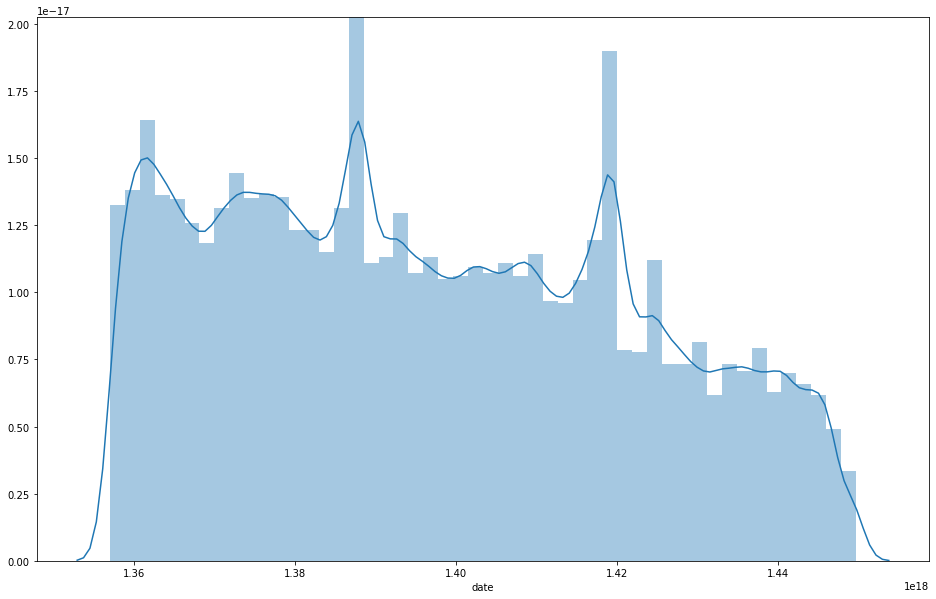

In [14]:
plt.rcParams['figure.figsize'] = (16, 10)
sns.distplot(train['date'])
plt.show()

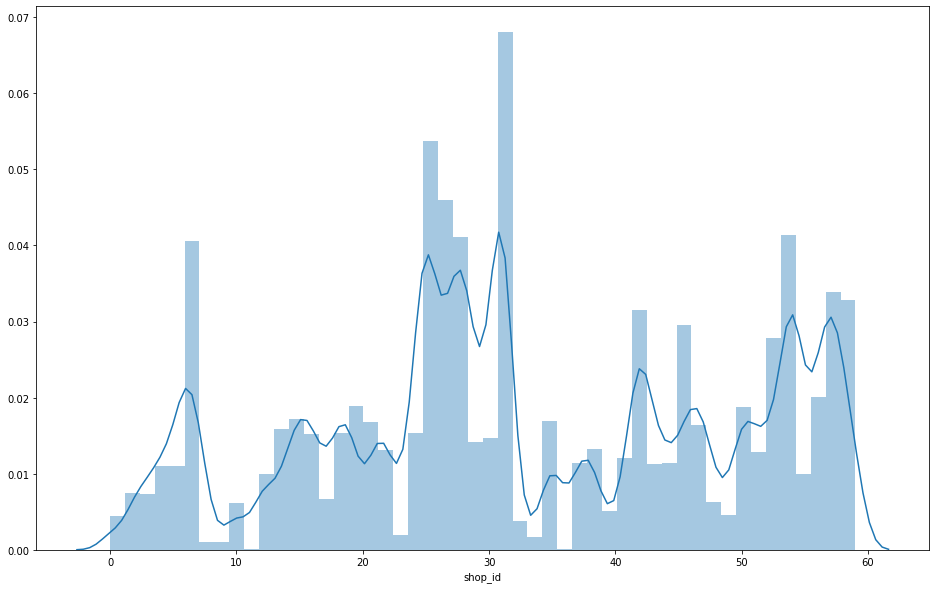

In [15]:
sns.distplot(train['shop_id'])
plt.show()

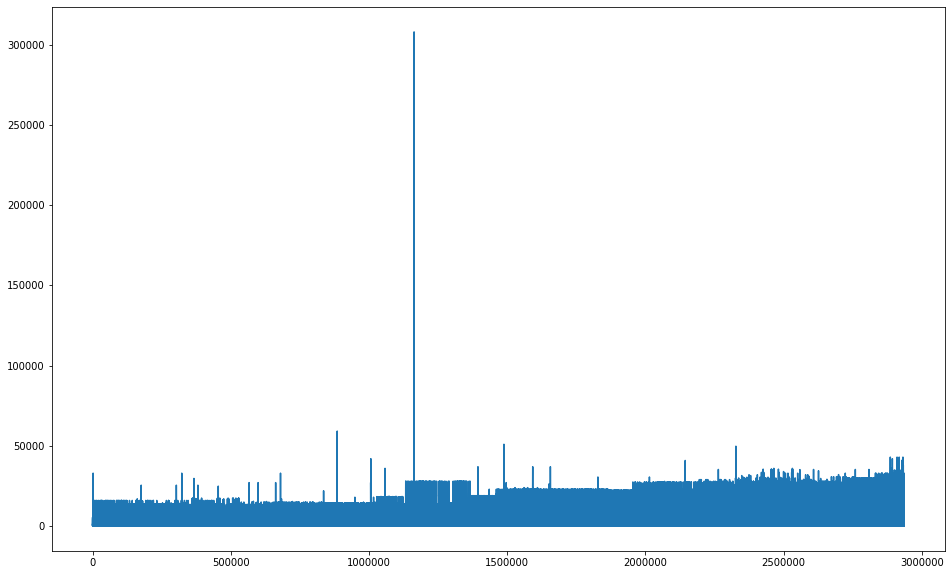

In [16]:
plt.plot(train['item_price'])
plt.show()

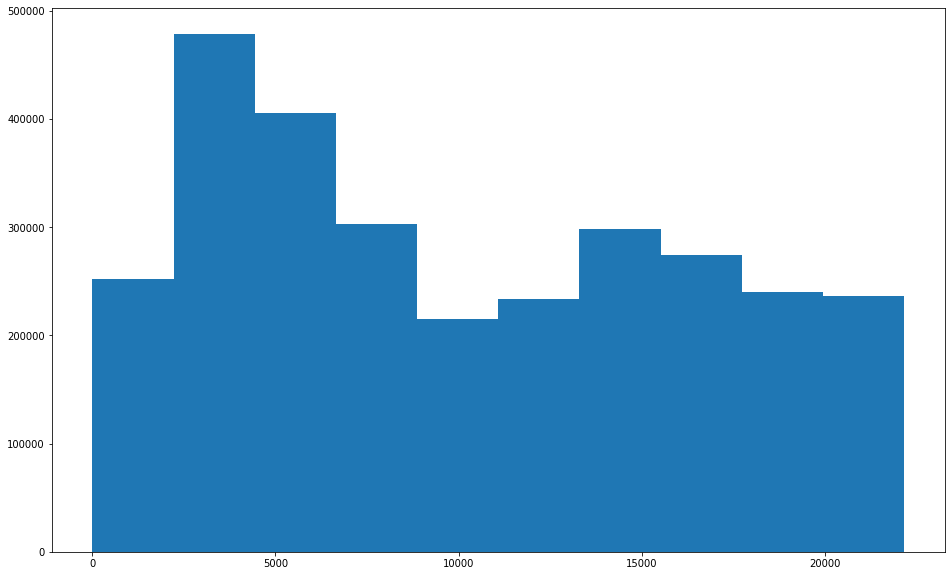

In [17]:
plt.hist(train['item_id'])
plt.show()

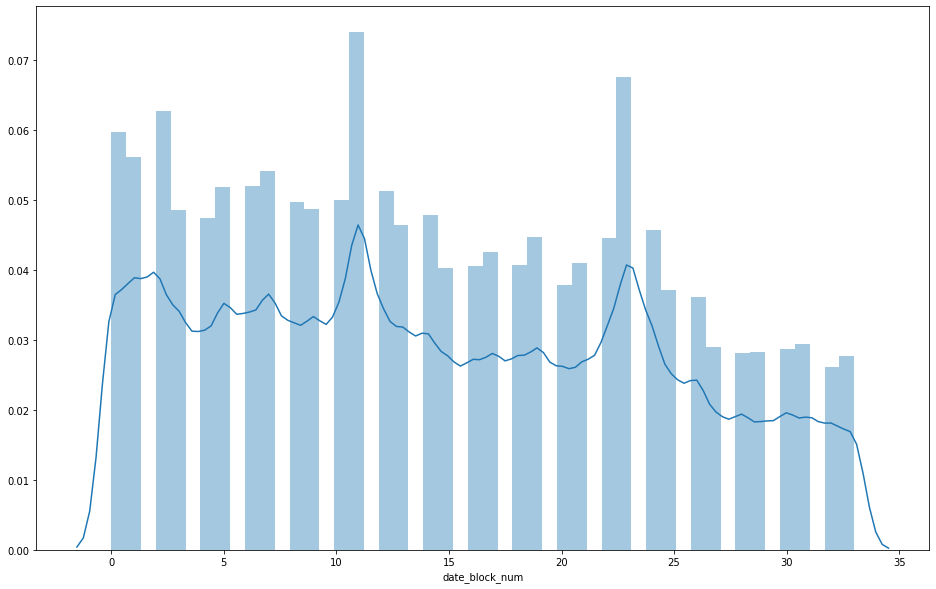

In [18]:
sns.distplot(train['date_block_num'])
plt.show()

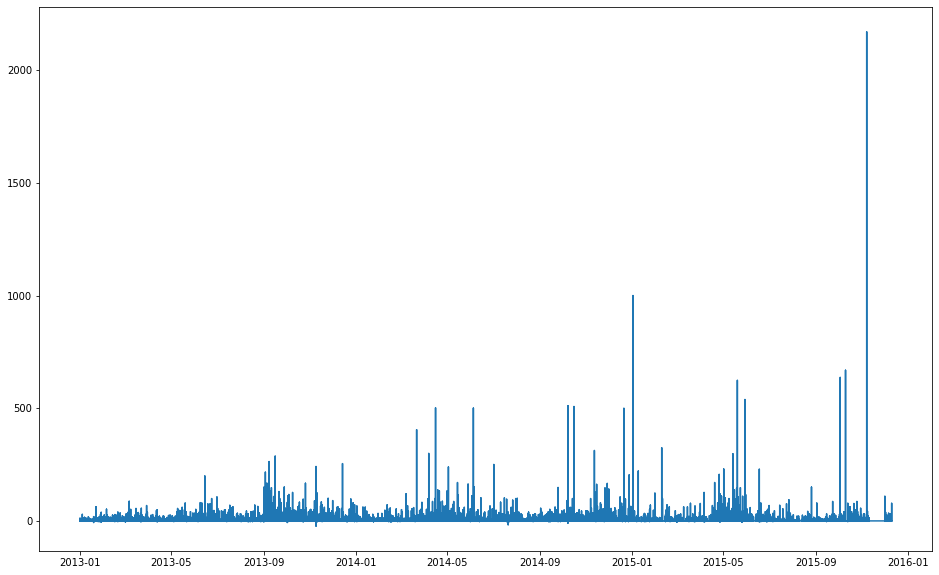

In [19]:
plt.plot(train['date'].sort_values(), train['item_cnt_day'])
plt.show()

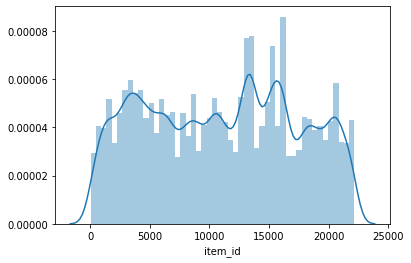

In [20]:
plt.figure(figsize=(6, 4))
sns.distplot(test['item_id'])
plt.show()

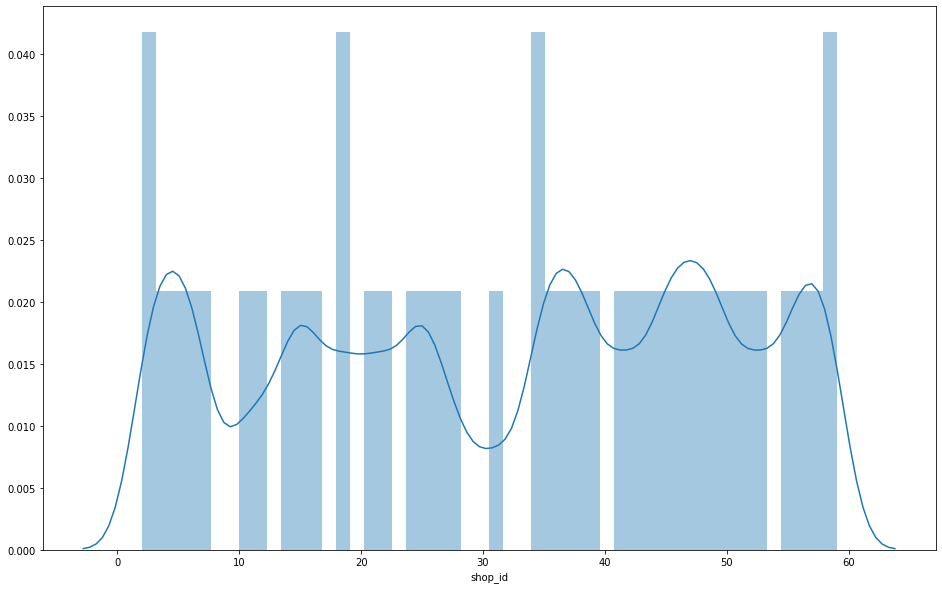

In [21]:
sns.distplot(test['shop_id'])
plt.show()

### Deep dive into Data

다시 한번 아이템에 주목해볼까요?

In [22]:
train[['item_name', 'item_category_id']].sample(n=20000, random_state=2020).sample(50, random_state=2020)

,item_name,item_category_id
2520542,"Средиземье: Тени Мордора [PC, Jewel, русские с...",30
408018,"Dead Space 3 [Xbox 360, русские субтитры]",23
450957,Стругацкие А. и Б. За миллиард лет до конца св...,43
1269965,"World of Warcraft Gold [PC, Jewel, 14 дней, ру...",30
884017,"Far Cry 3 [PS3, русская версия]",19
1766891,Xbox 360 Kinect Sensor Xbox 360 CS/EL/HU/PL/RU...,6
1187604,3D Crystal Puzzle Замок XL,67
1685157,ГОЛОДНЫЕ ИГРЫ: И ВСПЫХНЕТ ПЛАМЯ (регион),40
1173311,PS4: Камера (PlayStation Camera: CUH-ZEY1: SCEE),3
2243565,"LittleBigPlanet 3 [PS3, русская версия]",19


러시아라서 잘 알 수는 없지만, 뭔가 익숙한 영어들이 모이긴 합니다. `mp3-CD` 라던지, `PC` 라던지, `DVD` 라던지.. 자세히 보면 `Minecraft` 마인크래프트도 있네요! 아마 이 상점들은 게임 상점들 데이터였을 것 같습니다.

카테고리별로 한번 출력을 해볼까요?

In [23]:
train[train['item_category_id'] == 20].item_name.head(50)

1029535           Call of Duty: Ghosts [PS4, русская версия]
1029536           Call of Duty: Ghosts [PS4, русская версия]
1029537           Call of Duty: Ghosts [PS4, русская версия]
1029538           Call of Duty: Ghosts [PS4, русская версия]
1029625    Assassin's Creed IV. Черный флаг. Специальное ...
1030933                  FIFA 14 [PS4, русская документация]
1030934                  FIFA 14 [PS4, русская документация]
1031160                          Knack [PS4, русская версия]
1031161                          Knack [PS4, русская версия]
1031162                          Knack [PS4, русская версия]
1031187                          Knack [PS4, русская версия]
1031309      Killzone: В плену сумрака [PS4, русская версия]
1031310      Killzone: В плену сумрака [PS4, русская версия]
1031311      Killzone: В плену сумрака [PS4, русская версия]
1031312      Killzone: В плену сумрака [PS4, русская версия]
1032433                          Knack [PS4, русская версия]
1032434                 

예시로 아이템 카테고리 20을 확인해보았습니다. 대충 공통적으로 `[PS4, русская версия]`를 가지고 있어요. 이것에 대한 정보가 카테고리인 것 같습니다.

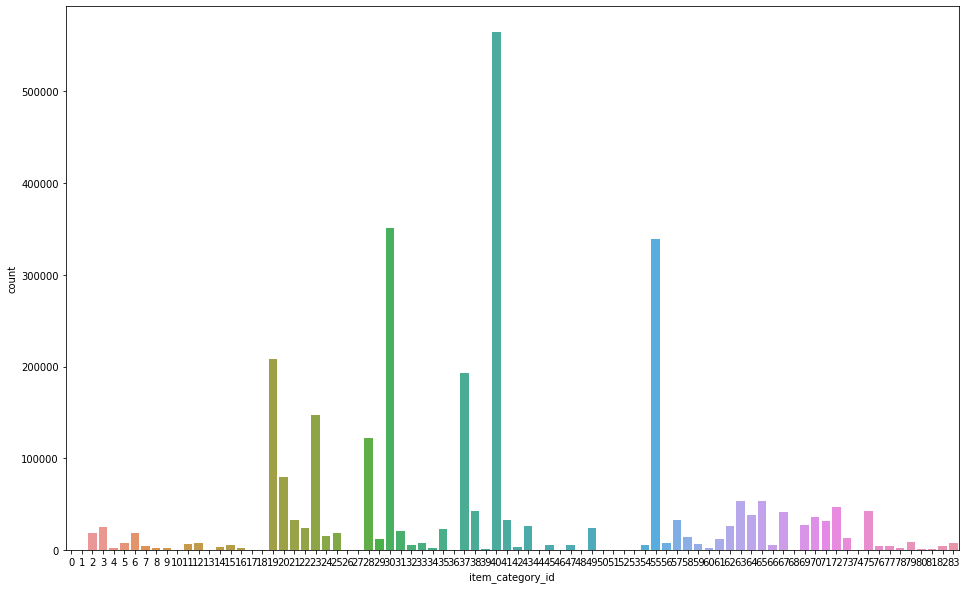

In [24]:
sns.countplot(train['item_category_id'])
plt.show()

가장 두드러지게 많이 팔린 것이 있습니다. 카테고리 40인데요, 아마 `PS`와 관련된 것이 아닐까 싶습니다. 끝으로 갈수록 인기가 많지 않은 내용들인 것 같습니다. 

인기있는 상위 30개 정도의 카테고리는 분류하고, 나머지는 others로 분류하는 것도 괜찮은 방법이 될 것 같습니다. 

In [25]:
train['item_cnt_day'].value_counts().head(10)

 1    2629372
 2     194201
 3      47350
 4      19685
 5      10474
-1       7252
 6       6338
 7       4057
 8       2903
 9       2177
Name: item_cnt_day, dtype: int64

`item_cnt_day`는 얼마나 팔렸는가에 대한 정보인 것 같습니다. 한 아이템이 나타난 빈도수가 적더라도, `item_cnt_day`에 따라 얼마나 팔렸는지가 달라질 수 있겠네요.

그리고 자세히 보면 음수 값도 나옵니다. 환불된 값을 나타내는 것 같아요. 


## 3. Data Preprocessing

그렇다면 다시 정리해봅시다.

1. test 데이터에서는 shop_id와 item_id만 있습니다. category와 price를 넣어주면 좋을 것 같습니다.
2. train 데이터에서 월별 item_cnt_month를 찾아주어야 합니다. `df.groupby(['shop_id', 'item_id']).sum()`으로 구하면 될 것 같습니다.
3. 카테고리는 80여가지가 있습니다. 상위 15개~20개 정도만 남기고 나머지는 others로 한꺼번에 처리해줍시다. **범주형 데이터**이니 판다스의 `pd.get_dummies`를 사용하면 될 것 같습니다.
4. price도 하나의 척도이나, 위의 데이터는 게임 데이터입니다. 따라서 '어떤'게임을 사는지가 중요하지, 가격은 크게 중요하지 않다고 생각하겠습니다. 따라서 정규화를 시켜줍시다.
5. shop_id와 item_id를 함께 묶어서 생각해줍시다. 새로운 인덱스를 하나 만든다고 생각하면 될 것 같습니다.

### Data Leakage

데이터를 그럼 추출해봅시다.

우리는 test에 있는 shop과 item만 찾아서 train하면 좋을 것 같습니다. 한번 확인해볼까요?

In [27]:
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()
# Only shops that exist in test set.
lk_train = train[train['shop_id'].isin(test_shop_ids)]
# Only items that exist in test set.
lk_train = lk_train[lk_train['item_id'].isin(test_item_ids)]

print('Data set size before leaking:', train.shape[0])
print('Data set size after leaking:', lk_train.shape[0])

Data set size before leaking: 2935849
Data set size after leaking: 1224439


### Data Cleaning

위에서 살펴보았을 때 `item_price`도 좀 이상한 분포를 보였었습니다. 일단 가격이 0보다 큰것들만 남겨둡시다.

In [28]:
train = lk_train.query('item_price > 0')
train.shape

(1223677, 10)

### test 데이터 조금 다듬기

그럼 이제 테스트 데이터를 조금 다듬어봅시다. 여기서 아이템 아이디와 shop_id에 맞게 가격과 item_category_id를 넣고싶습니다.

In [29]:
price = train[['item_id', 'item_price']]
price = price.groupby('item_id', as_index=False).mean().astype(int)

In [30]:
new_test = pd.merge(test, price, how='outer')
new_test = pd.merge(new_test, items)
new_test = new_test[['ID', 'shop_id', 'item_id', 'item_price', 'item_category_id']]
new_test.isnull().sum()

ID                      0
shop_id                 0
item_id                 0
item_price          16128
item_category_id        0
dtype: int64

결측치에는 평균값을 넣어줍시다.

In [31]:
price['item_price'].mean()

1023.504877014419

In [32]:
new_test = new_test.fillna(1023)
new_test.isnull().sum()

ID                  0
shop_id             0
item_id             0
item_price          0
item_category_id    0
dtype: int64

### `item_cnt_month` 만들기

그럼 우리의 target data인 `item_cnt_month`를 만들어봅시다.

In [33]:
new_train = train.groupby(['date_block_num', 'shop_id', 'item_id']).sum().reset_index()
new_train = new_train[['date_block_num', 'shop_id', 'item_id', 'item_cnt_day']]
new_train.rename(columns={'item_cnt_day' : 'item_cnt_month'}, inplace=True)
new_train

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,33,1
1,0,2,482,1
2,0,2,491,1
3,0,2,839,1
4,0,2,1007,3
...,...,...,...,...
599932,33,59,22087,6
599933,33,59,22088,2
599934,33,59,22091,1
599935,33,59,22100,1


In [34]:
new_train = pd.merge(new_train, items)
new_train = pd.merge(new_train, price, how='outer')
new_train = new_train.drop(['item_name'], axis = 1)
new_train

,date_block_num,shop_id,item_id,item_cnt_month,item_category_id,item_price
0,0,2,33,1,37,249
1,0,6,33,2,37,249
2,0,7,33,1,37,249
3,0,15,33,1,37,249
4,0,16,33,1,37,249
...,...,...,...,...,...,...
599932,33,55,9103,11,54,50
599933,33,55,9107,6,54,50
599934,33,55,10204,16,31,399
599935,33,55,12733,2,76,1490


잘 들어갔네요!

### test, train 묶어서 한번에 전처리하기

그럼 이제 합쳐서 전처리를 합시다. 두번 하기 힘드니까요!!

In [35]:
train_len = len(new_train)
train_test = pd.concat([new_train, new_test], axis=0)
train_test

,date_block_num,shop_id,item_id,item_cnt_month,item_category_id,item_price,ID
0,0.0,2,33,1.0,37,249.0,NaN
1,0.0,6,33,2.0,37,249.0,NaN
2,0.0,7,33,1.0,37,249.0,NaN
3,0.0,15,33,1.0,37,249.0,NaN
4,0.0,16,33,1.0,37,249.0,NaN
...,...,...,...,...,...,...,...
214195,NaN,46,969,NaN,37,502.0,193799.0
214196,NaN,41,969,NaN,37,502.0,198899.0
214197,NaN,44,969,NaN,37,502.0,203999.0
214198,NaN,39,969,NaN,37,502.0,209099.0


### item_category 더미 칼럼 만들기

Item_category는 범주형 변수이기때문에 column으로 따로 빼서 생각하려고 합니다.

In [36]:
category = pd.get_dummies(train_test['item_category_id'], prefix='item_category')
train_test = pd.concat([train_test, category], axis=1)

### item_price는 정규화!

item_price는 정규화를 해줍시다.

In [37]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
fitted_price = min_max_scaler.fit_transform(train_test['item_price'].to_frame())
fitted_price

array([[0.00612714],
       [0.00612714],
       [0.00612714],
       ...,
       [0.01245436],
       [0.01245436],
       [0.01245436]])

In [38]:
train_test['item_price_norm'] = fitted_price
train_test = train_test.drop(['item_price'], axis=1)

### test의 date_block_num은 34!

0부터 33까지 train의 date block num이라면 test의 date block num은 34입니다.

In [39]:
train_test['date_block_num'] = train_test['date_block_num'].fillna(34)
train_test

,date_block_num,shop_id,item_id,item_cnt_month,item_category_id,ID,item_category_0,item_category_2,item_category_3,item_category_5,...,item_category_72,item_category_73,item_category_74,item_category_75,item_category_76,item_category_77,item_category_78,item_category_79,item_category_83,item_price_norm
0,0.0,2,33,1.0,37,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.006127
1,0.0,6,33,2.0,37,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.006127
2,0.0,7,33,1.0,37,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.006127
3,0.0,15,33,1.0,37,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.006127
4,0.0,16,33,1.0,37,NaN,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.006127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,34.0,46,969,NaN,37,193799.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.012454
214196,34.0,41,969,NaN,37,198899.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.012454
214197,34.0,44,969,NaN,37,203999.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.012454
214198,34.0,39,969,NaN,37,209099.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.012454


### shop_id도 범주화로 생각해 칼럼으로 빼줍시다.

In [40]:
shop = pd.get_dummies(train_test['shop_id'], prefix='shop')
train_test = pd.concat([train_test, shop], axis=1)
min_max_scaler = preprocessing.MinMaxScaler()
fitted_item = min_max_scaler.fit_transform(train_test['item_id'].to_frame())
train_test['item_id_norm'] = fitted_item
train_test = train_test.drop(['item_category_id', 'shop_id', 'ID', 'item_id'], axis=1)
train_test

,date_block_num,item_cnt_month,item_category_0,item_category_2,item_category_3,item_category_5,item_category_6,item_category_7,item_category_9,item_category_11,...,shop_49,shop_50,shop_52,shop_53,shop_55,shop_56,shop_57,shop_58,shop_59,item_id_norm
0,0.0,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000136
1,0.0,2.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000136
2,0.0,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000136
3,0.0,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000136
4,0.0,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,34.0,NaN,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.042418
214196,34.0,NaN,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.042418
214197,34.0,NaN,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.042418
214198,34.0,NaN,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.042418


전처리가 끝났습니다. 이제 모델을 학습시켜줍시다.

## 모델 학습하기

In [41]:
train = train_test[:train_len]
test = train_test[train_len:]

print(len(train), len(test))

599937 214200


In [42]:
X_train = train.drop(['item_cnt_month'], axis=1)
y = train['item_cnt_month']

test = test.drop(['item_cnt_month'], axis=1)

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y, random_state=2020, test_size = 0.2
)

print(X_train.shape, X_valid.shape)

(479949, 107) (119988, 107)


In [44]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

xg_reg = xgb.XGBRegressor()

In [45]:
xg_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [46]:
y_valid_pred = xg_reg.predict(X_valid)
xg_rmse = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
print("XGBoost RMSE : {}".format(xg_rmse))

XGBoost RMSE : 6.998355165837467


## 제출하기

이제 제출합시다!!

In [47]:
#submission file 만들기
submission = pd.read_csv('./data/sample_submission.csv')

In [48]:
y_pred = xg_reg.predict(test)

In [49]:
submission['item_cnt_month'] = y_pred
submission.to_csv("XGBoost.csv", index=False)

이 폴더에 만들어진 `XGBoost.csv` 파일을 제출하면 됩니다 ^^

물론 다른 모델도 학습시켜볼 수 있으나.. 계속 커널이 죽네요!

In [50]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(random_state=2020)
decision_tree.fit(X_train, y_train)
decision_tree_valid_pred = decision_tree.predict(X_valid)
decision_tree_rmse = np.sqrt(mean_squared_error(y_valid, decision_tree_valid_pred))
print("DecisionTree RMSE : {}".format(decision_tree_rmse))

DecisionTree RMSE : 7.631301680788212


In [53]:
decision_tree_pred = decision_tree.predict(test)
decision_tree_submission = submission
decision_tree_submission['item_cnt_month'] = decision_tree_pred
decision_tree_submission.to_csv('DecisionTree.csv', index=False)